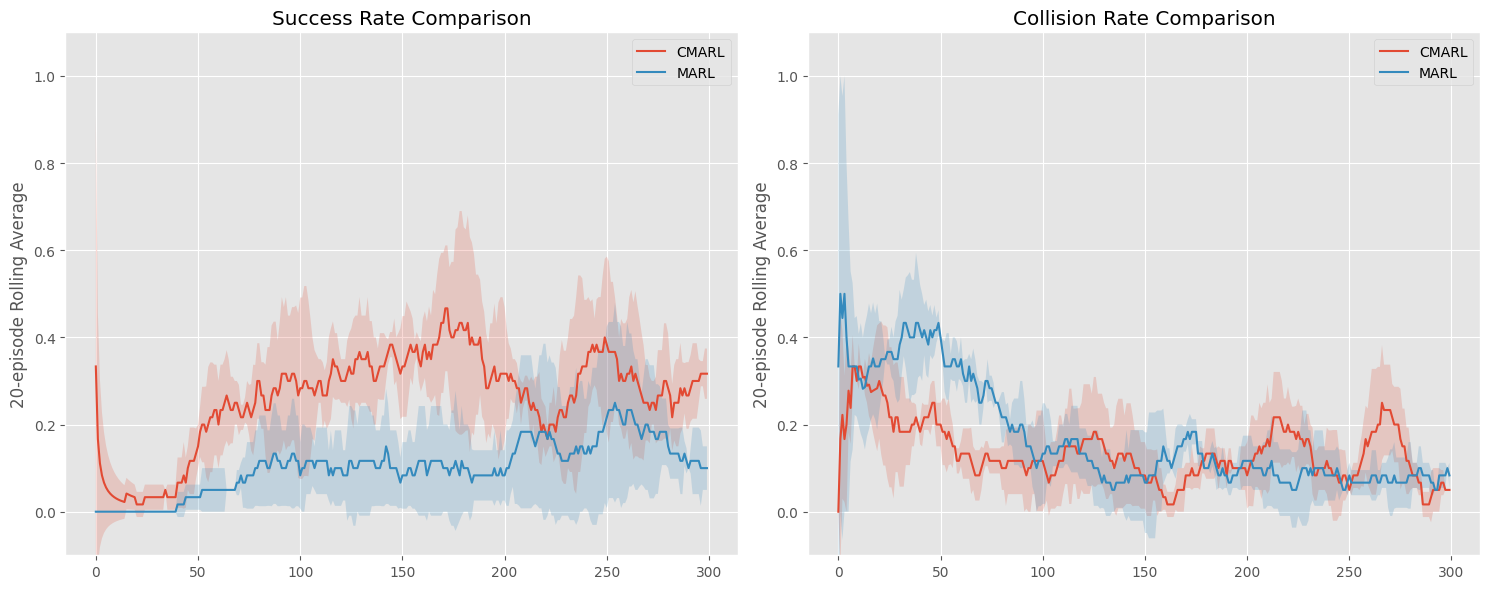

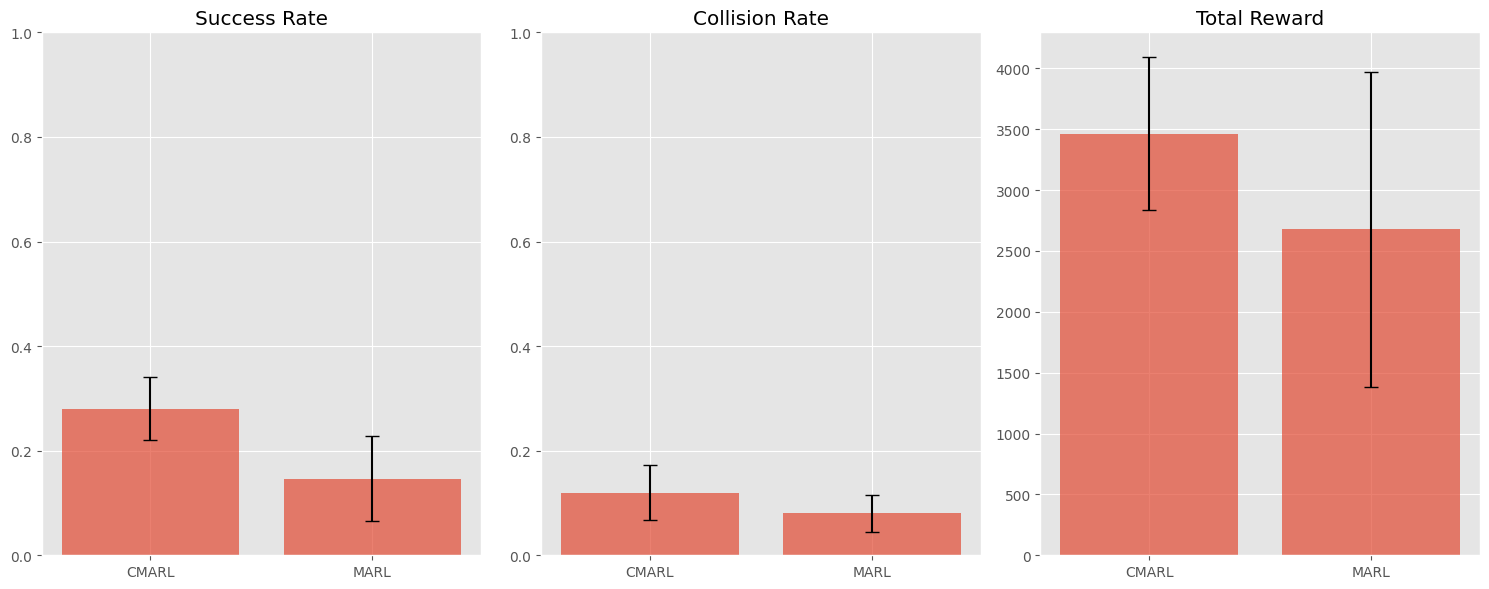

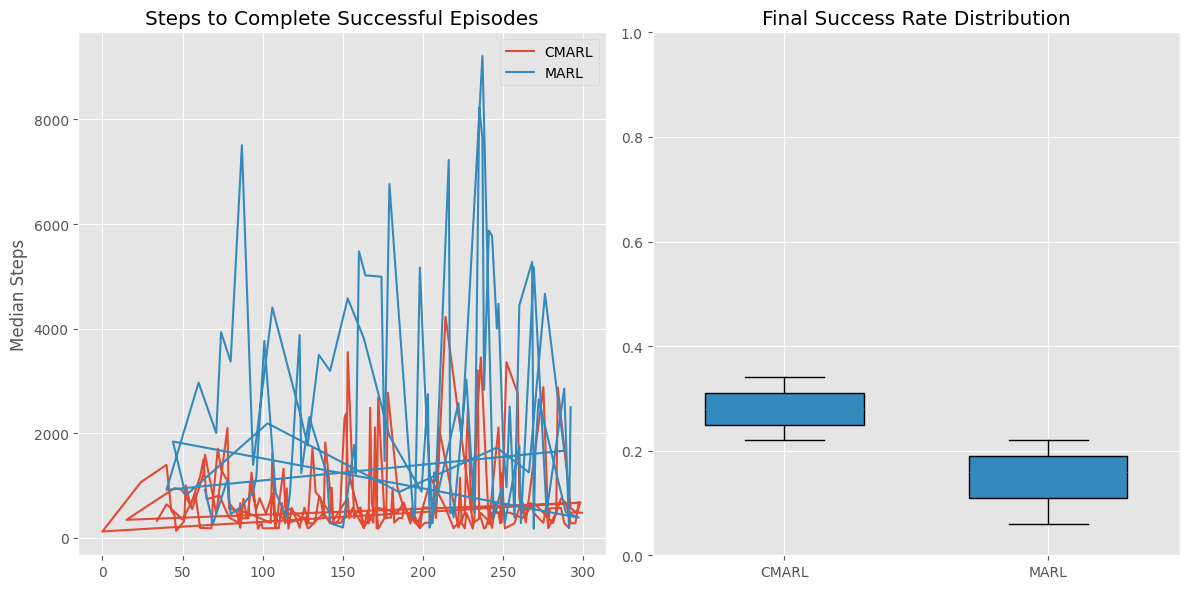

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

# Data loading
def load_results(algorithm, seeds):
    dfs = []
    for seed in seeds:
        path = f"results/{algorithm}_seed_{seed}/results.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df['algorithm'] = algorithm
            df['seed'] = seed
            dfs.append(df)
    return pd.concat(dfs)

# Load all data
seeds = [42, 43, 44]
algorithms = ['CMARL', 'MARL']
combined_df = pd.concat([load_results(algo, seeds) for algo in algorithms])

# Calculate rolling averages
window_size = 20
combined_df['rolling_success'] = combined_df.groupby(['algorithm', 'seed'])['success'].transform(
    lambda x: x.rolling(window_size, min_periods=1).mean()
)
combined_df['rolling_collision'] = combined_df.groupby(['algorithm', 'seed'])['collision'].transform(
    lambda x: x.rolling(window_size, min_periods=1).mean()
)

# Training progress visualization
plt.figure(figsize=(15, 6))

# Success rate plot
plt.subplot(1, 2, 1)
for algo in algorithms:
    algo_data = combined_df[combined_df['algorithm'] == algo]
    episodes = algo_data['episode'].unique()
    mean_success = [algo_data[algo_data['episode'] == ep]['rolling_success'].mean() for ep in episodes]
    std_success = [algo_data[algo_data['episode'] == ep]['rolling_success'].std() for ep in episodes]
    
    plt.plot(episodes, mean_success, label=algo)
    plt.fill_between(episodes, np.array(mean_success)-np.array(std_success), 
                     np.array(mean_success)+np.array(std_success), alpha=0.2)

plt.title('Success Rate Comparison')
plt.ylabel('20-episode Rolling Average')
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()

# Collision rate plot
plt.subplot(1, 2, 2)
for algo in algorithms:
    algo_data = combined_df[combined_df['algorithm'] == algo]
    episodes = algo_data['episode'].unique()
    mean_collision = [algo_data[algo_data['episode'] == ep]['rolling_collision'].mean() for ep in episodes]
    std_collision = [algo_data[algo_data['episode'] == ep]['rolling_collision'].std() for ep in episodes]
    
    plt.plot(episodes, mean_collision, label=algo)
    plt.fill_between(episodes, np.array(mean_collision)-np.array(std_collision), 
                     np.array(mean_collision)+np.array(std_collision), alpha=0.2)

plt.title('Collision Rate Comparison')
plt.ylabel('20-episode Rolling Average')
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Final performance comparison
final_perf = combined_df[combined_df['episode'] >= 250].groupby(
    ['algorithm', 'seed']).agg({
        'success': 'mean',
        'collision': 'mean',
        'total_reward': 'mean'
    }).reset_index()

plt.figure(figsize=(15, 6))
metrics = ['success', 'collision', 'total_reward']
titles = ['Success Rate', 'Collision Rate', 'Total Reward']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    plt.subplot(1, 3, i+1)
    
    algo_means = [final_perf[final_perf['algorithm'] == algo][metric].mean() for algo in algorithms]
    algo_stds = [final_perf[final_perf['algorithm'] == algo][metric].std() for algo in algorithms]
    
    bars = plt.bar(range(len(algorithms)), algo_means, yerr=algo_stds,
                 capsize=5, alpha=0.7)
    
    plt.xticks(range(len(algorithms)), algorithms)
    plt.title(title)
    if metric in ['success', 'collision']:
        plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Advanced analysis
plt.figure(figsize=(12, 6))

# Steps to success comparison
plt.subplot(1, 2, 1)
for algo in algorithms:
    algo_data = combined_df[(combined_df['success'] == 1) & (combined_df['algorithm'] == algo)]
    plt.plot(algo_data['episode'], algo_data['total_reward'], label=algo)
plt.title('Reward in Successful Episodes')
plt.ylabel('Total Reward')

plt.title('Steps to Complete Successful Episodes')
plt.ylabel('Median Steps')
plt.legend()

# Success rate distribution
plt.subplot(1, 2, 2)
for i, algo in enumerate(algorithms):
    data = final_perf[final_perf['algorithm'] == algo]['success']
    plt.boxplot(data, positions=[i], widths=0.6, patch_artist=True)

plt.xticks(range(len(algorithms)), algorithms)
plt.title('Final Success Rate Distribution')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()